In [901]:
import os
import librosa 
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
%config InlineBackend.figure_format = 'retina'

In [902]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [903]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [945]:
def normalized_mean_spectrum(*args, n_fft=2048):
    
    data = np.zeros(0)
    
    # load audio
    for audio_file in args:
        audio_data, fs = sf.read(audio_file)
        data = np.concatenate((data, audio_data), axis=0)
    
    # apply a bandpass filter to focus on speech
    data = butter_bandpass_filter(data, 50, 8000, fs, order=5)
    
    # peform STFT
    freq_data = np.abs(librosa.core.stft(data, n_fft=n_fft, hop_length=int(n_fft/2)))
    freq_data_db = librosa.amplitude_to_db(freq_data, ref=np.max)
    
    # throw away silent frames
    #freq_data_db = np.where(np.np.max(freq_data_db, axis=1) > -80, freq_data_db)
    
    
    # find the frequency peak in the sprectrum
    f0_idx = np.argmax(freq_data_db, axis=0)
    f0_hz  = f0_idx * ((fs/2)/(n_fft/2))
    f0_a   = np.max(freq_data_db, axis=0)
    
    # only take frames with f0 amplitude greater than -80dBFS
    f0_idx = f0_idx[np.argwhere(f0_a > -80).flatten()]
    f0_hz  = f0_hz[np.argwhere(f0_a > -80).flatten()]
    freq_data_db = freq_data_db[:,np.argwhere(f0_a > -80).flatten()]
    
    shifted_freq_data_db = np.empty(shape=freq_data_db.shape)
    
    # shift so that the f0 is at index 1
    for frame_idx in np.arange(freq_data_db.shape[1]):
        shifted_freq_data_db[:,frame_idx] = np.roll(freq_data_db[:,frame_idx], - f0_idx[frame_idx])
    
    # take the mean among all frames
    #freq_data_mean = np.mean(shifted_freq_data_db, axis=1)
    
    ratio_density = 250
    freq_data_mean = np.zeros(shape=(ratio_density,))
    ratio_idx = np.linspace(1.0, 2.1, ratio_density)
    
    for frame_idx in np.arange(0, freq_data_db.shape[1]):
        for bin_idx in np.arange(0, int(1.1 * f0_idx[frame_idx]+1)):
            current_idx = f0_idx[frame_idx] + bin_idx
            current_ratio = current_idx / f0_idx[frame_idx]
            r_idx = np.squeeze(np.argwhere(ratio_idx == find_nearest(ratio_idx, current_ratio)))
            #print(bin_idx, current_ratio, r_idx)
            freq_data_mean[r_idx] -= freq_data_db[bin_idx, frame_idx]
         
    freq_data_mean = freq_data_mean / freq_data_db.shape[1]
    
    # common ratios
    common = [6/5, 5/4, 4/3, 7/5, 3/2, 8/5, 5/3, 9/5, 2/1]
    
    # plot the results
    freqz = np.arange(0, (fs/2)+(fs/2)/n_fft, (fs/2)/(n_fft/2))
    
    plt.plot(ratio_idx, freq_data_mean, c='r', zorder=2)
    for ratio in common:
        plt.axvline(ratio_idx[np.argwhere(ratio_idx == find_nearest(ratio_idx, ratio))],
                    c='k', zorder=1, linewidth=0.2)
    plot_path = os.path.join('plots', os.path.basename(audio_file).replace('wav', 'png'))
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    
    #test_idx = 10
    #plt.semilogx(freqz, shifted_freq_data_db[:,test_idx])
    #plt.axvline(f0_hz[test_idx])
    #print(f0_idx[test_idx], f0_hz[test_idx], f0_a[test_idx])
    #plt.show()

audio/nila_speaking_javanese.wav


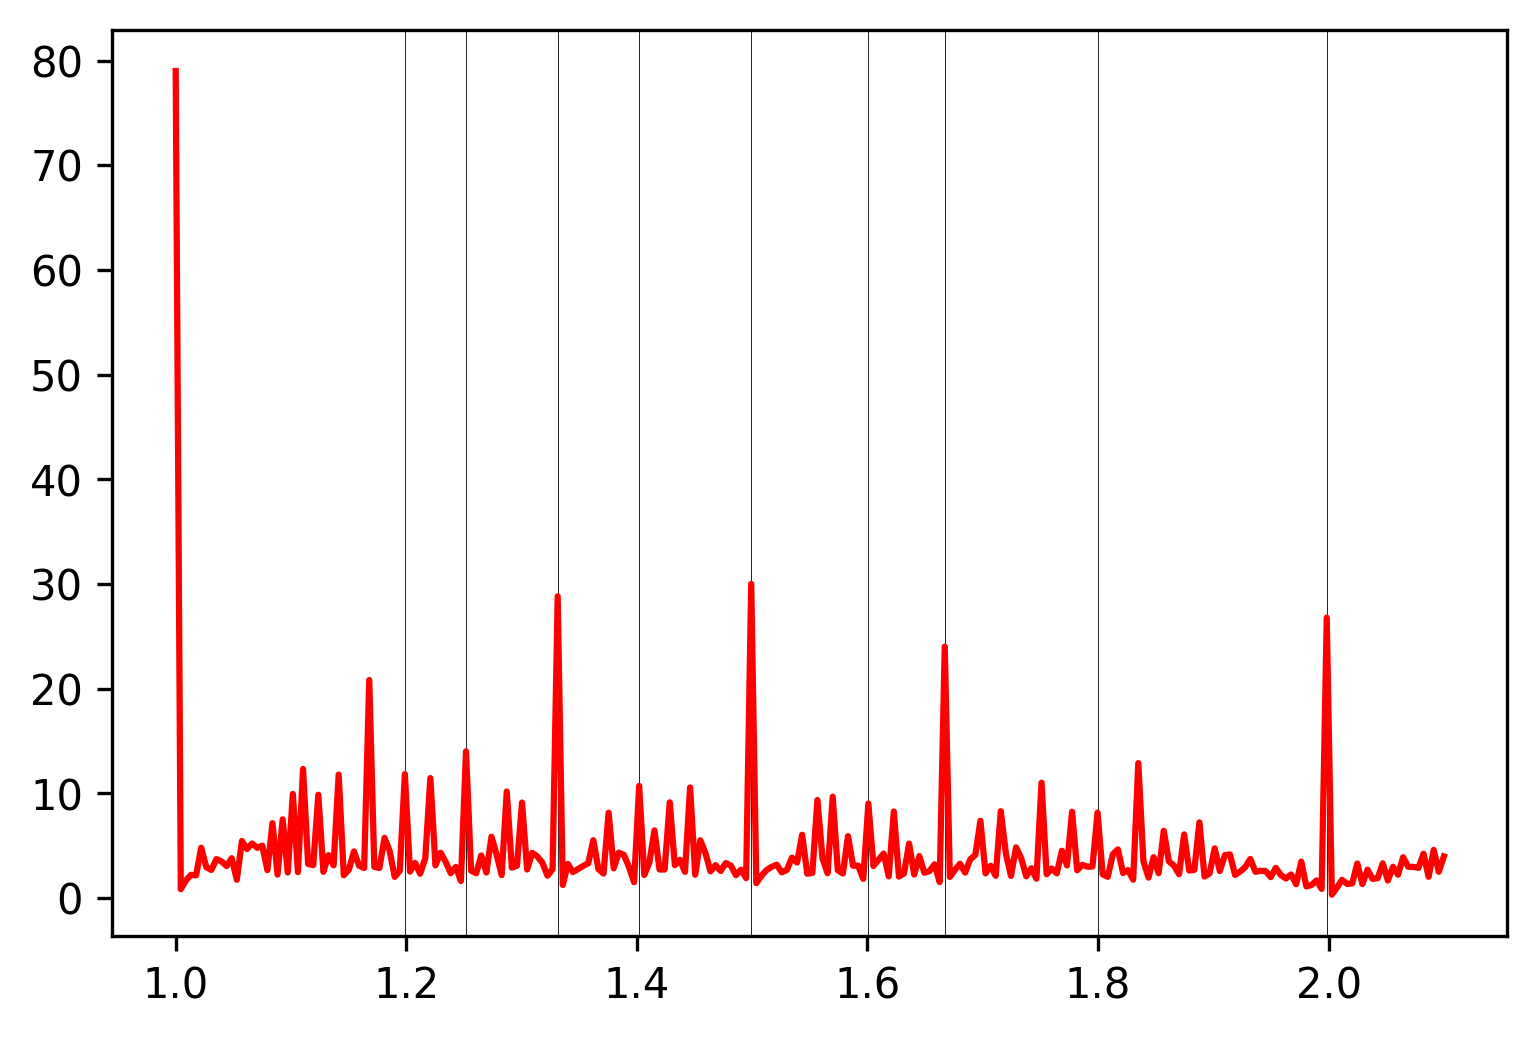

In [940]:
javanese1 = 'audio/nila_speaking_javanese.wav'
normalized_mean_spectrum(javanese1)

audio/rama_speaking_javanese.wav


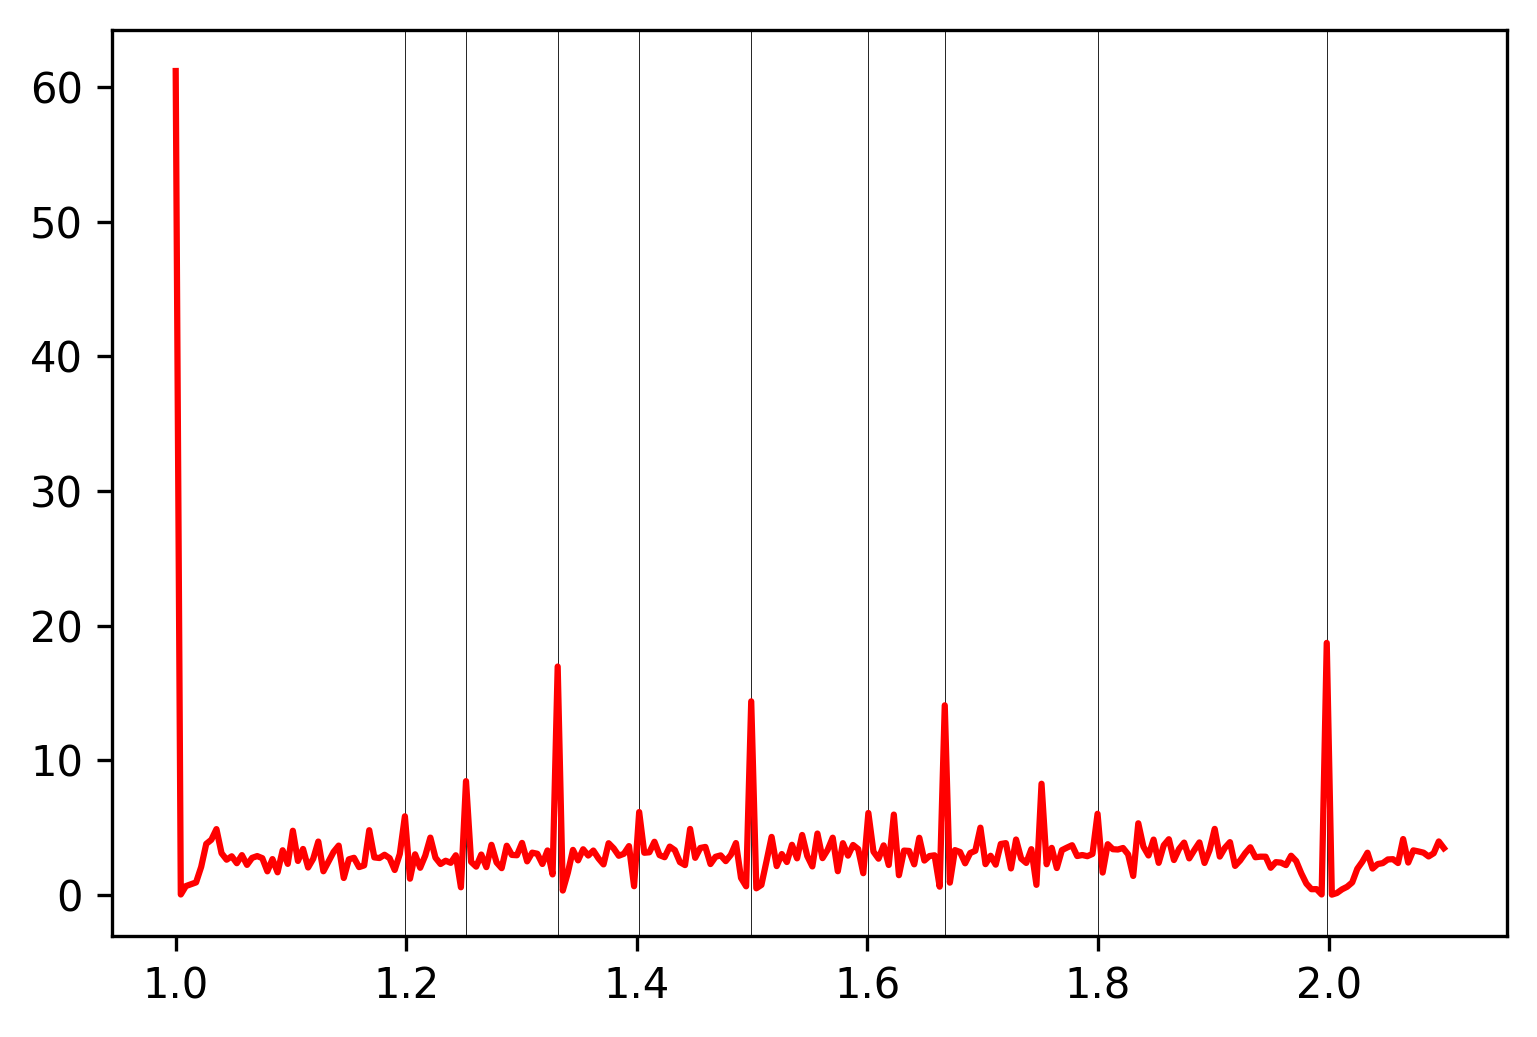

In [941]:
javanese2 = 'audio/rama_speaking_javanese.wav'
normalized_mean_spectrum(javanese2)

audio/ona_speaking_catalan.wav


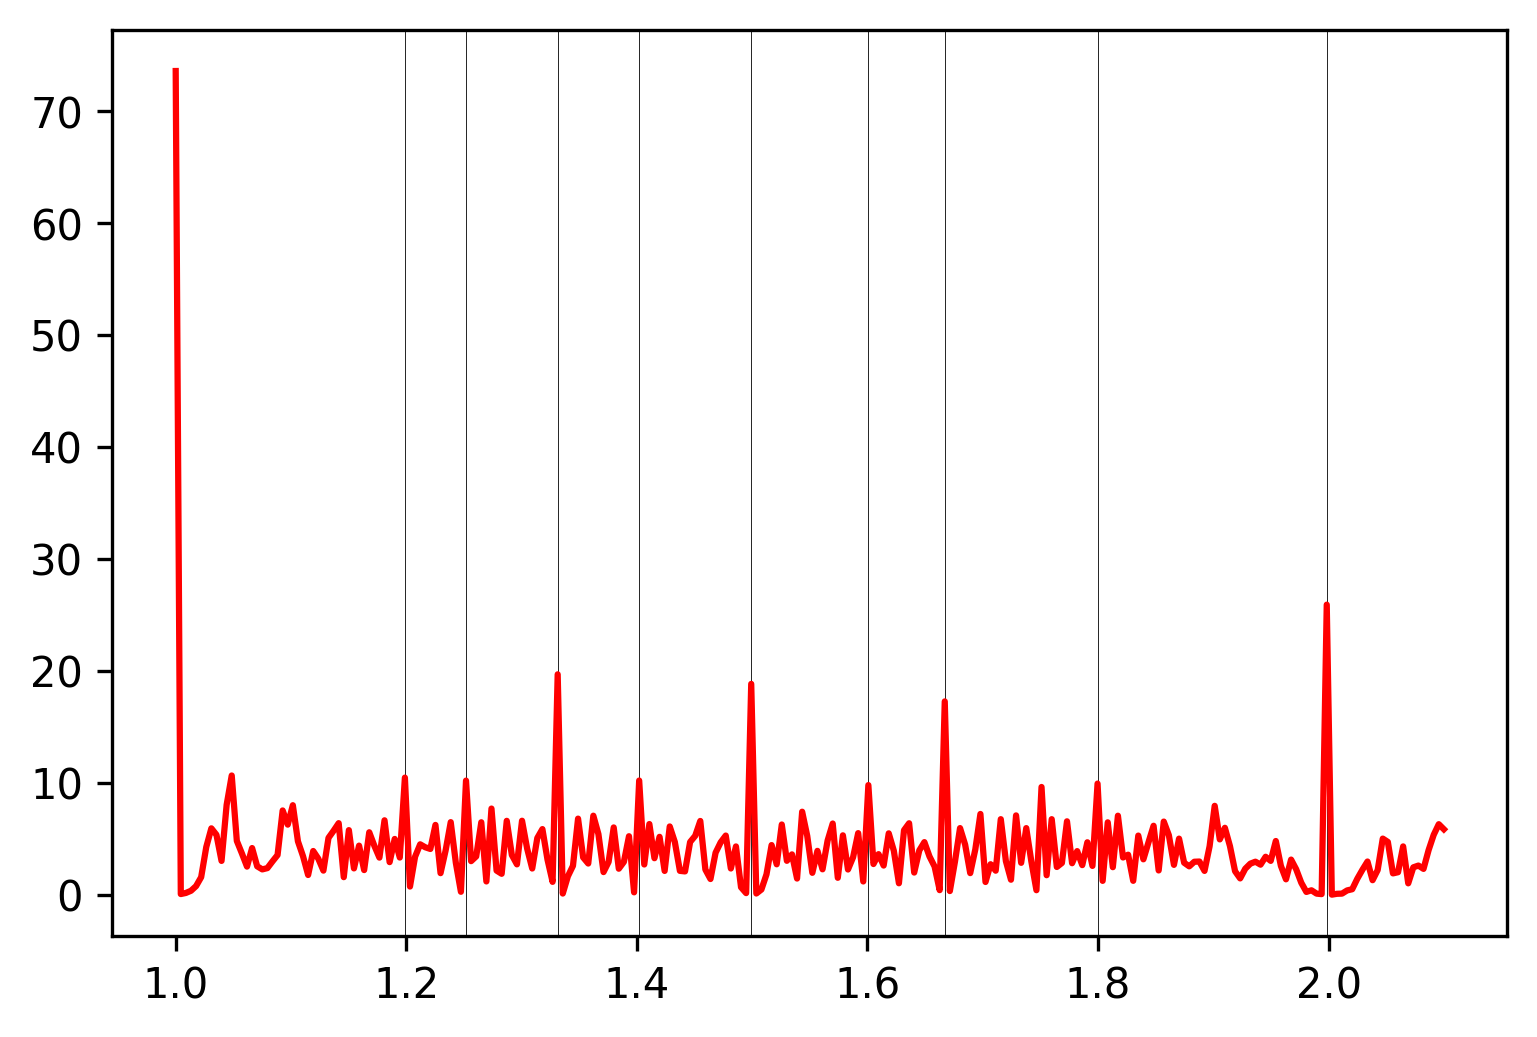

In [942]:
catalan = 'audio/ona_speaking_catalan.wav'
normalized_mean_spectrum(catalan)

audio/liam_speaking_english.wav


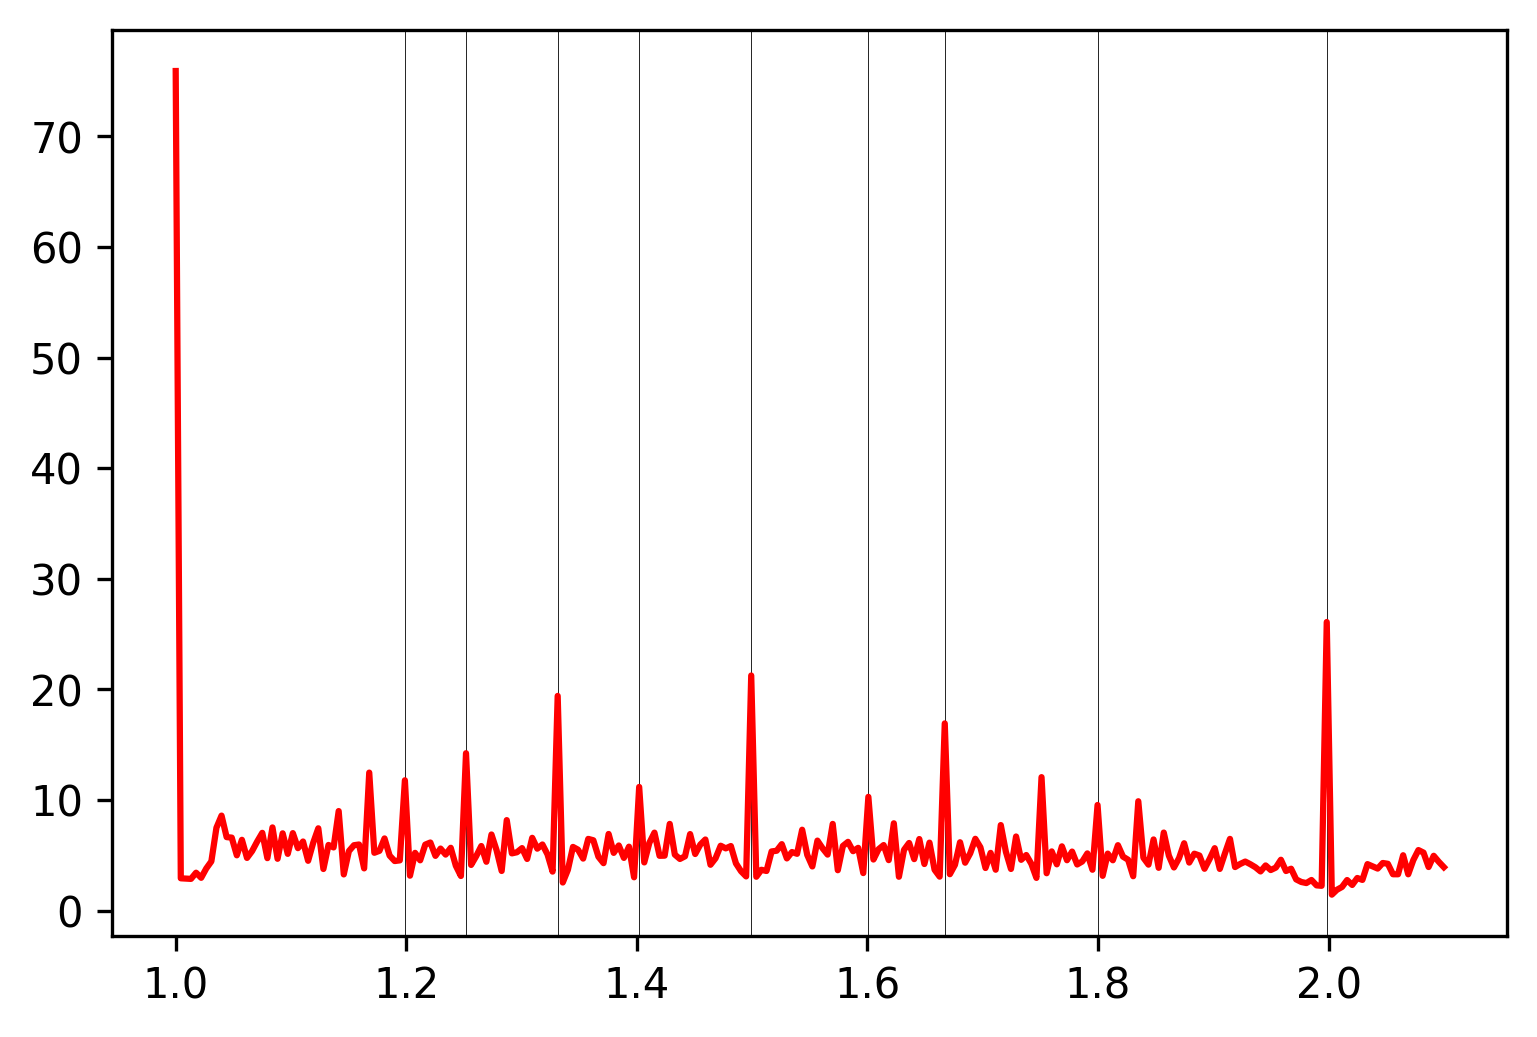

In [943]:
english = 'audio/liam_speaking_english.wav'
normalized_mean_spectrum(english)

audio/nila_speaking_javanese.wav
audio/rama_speaking_javanese.wav
audio/ona_speaking_catalan.wav
audio/liam_speaking_english.wav


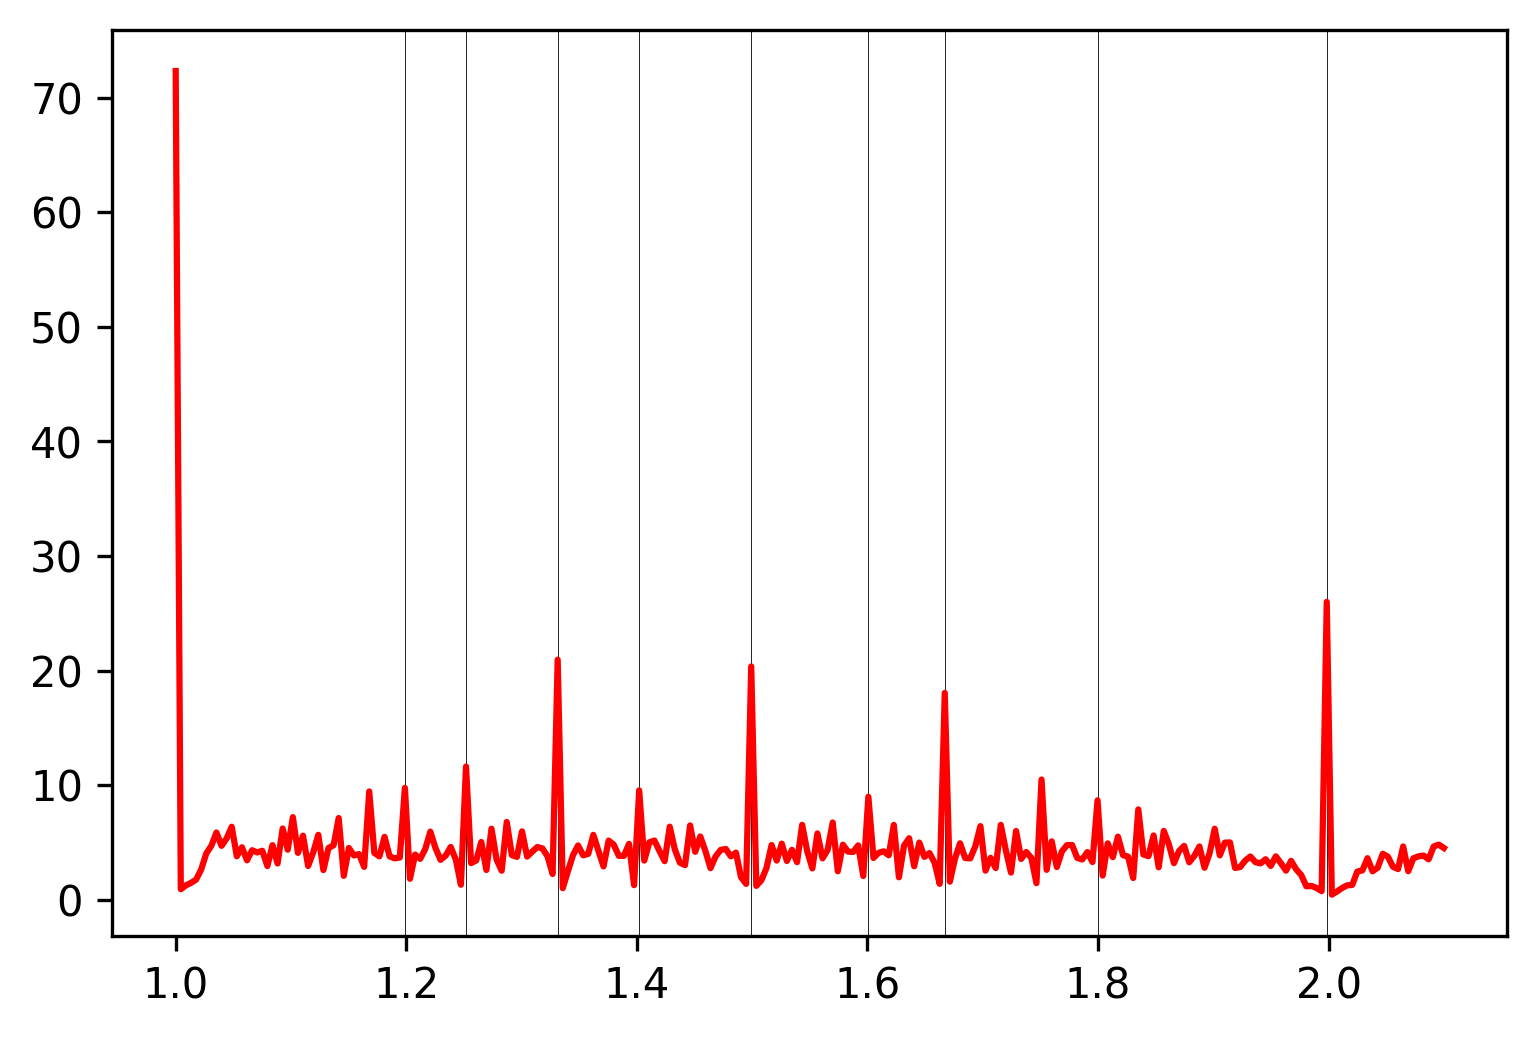

In [944]:
normalized_mean_spectrum(javanese1, javanese2, catalan, english)